In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import pickle
import pandas as pd
import random
import cv2
  
np.random.seed(0)

In [10]:
# Read data
data = pd.read_csv("signnames.csv")
  
with open('train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('test.p', 'rb') as f:
    test_data = pickle.load(f)
  
# Extracting the labels from the dictionaries
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
  
# Printing the shapes
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [11]:
def preprocessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img / 255
    return img
  
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))
  
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [12]:
datagen = ImageDataGenerator(width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  zoom_range = 0.2, 
                  shear_range = 0.1, 
                  rotation_range = 10)
datagen.fit(X_train)
  
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [17]:
num_classes = 43
  
def cnn_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), 
                     input_shape =(32, 32, 1), 
                     activation ='relu'))
      
    model.add(Conv2D(60, (5, 5), activation ='relu'))
    model.add(MaxPooling2D(pool_size =(2, 2)))
      
    model.add(Conv2D(30, (3, 3), activation ='relu'))
    model.add(Conv2D(30, (3, 3), activation ='relu'))
    model.add(MaxPooling2D(pool_size =(2, 2)))
      
    model.add(Flatten())
    model.add(Dense(500, activation ='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation ='softmax'))
      
    # Compile model
    model.compile(Adam(lr = 0.001), 
                  loss ='categorical_crossentropy', 
                  metrics =['accuracy'])
    return model
  
model = cnn_model()
history = model.fit_generator(datagen.flow(X_train, y_train, 
                            batch_size = 50), steps_per_epoch = 2000, 
                            epochs = 10, validation_data =(X_val, y_val), 
                            shuffle = 1)

Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[50,24,24,60] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node sequential_2/conv2d_9/Relu (defined at <ipython-input-17-e2c18b1b6f20>:28) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_6590]

Function call stack:
train_function


Text(0.5, 0, 'epoch')

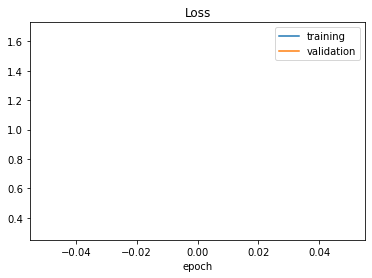

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

KeyError: 'acc'

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Loss: ', score[0])
print('Test Accuracy: ', score[1])